In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Bidirectional
import matplotlib.pyplot as plt

In [38]:
ticker = 'TSLA'
data = yf.download(ticker, start='2020-01-01', end='2024-12-01')

# 데이터 확인
print(data.head())

[*********************100%***********************]  1 of 1 completed

Price       Adj Close      Close       High        Low       Open     Volume
Ticker           TSLA       TSLA       TSLA       TSLA       TSLA       TSLA
Date                                                                        
2020-01-02  28.684000  28.684000  28.713333  28.114000  28.299999  142981500
2020-01-03  29.534000  29.534000  30.266666  29.128000  29.366667  266677500
2020-01-06  30.102667  30.102667  30.104000  29.333332  29.364668  151995000
2020-01-07  31.270666  31.270666  31.441999  30.224001  30.760000  268231500
2020-01-08  32.809334  32.809334  33.232666  31.215334  31.580000  467164500


In [40]:
data['MA20'] = data['Close'].rolling(window=20).mean()
data['MA50'] = data['Close'].rolling(window=50).mean()
data['LogReturn'] = np.log(data['Close'] / data['Close'].shift(1))
data['Return'] = (data['Close'] - data['Open']) / data['Open']

In [42]:
data = data.dropna()

In [44]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['Open', 'High', 'Low', 'Close', 'Volume', 'MA20', 'MA50', 'LogReturn', 'Return']])


In [46]:
# 시계열 데이터 생성
def create_dataset(dataset, time_steps=60):
    X, y = [], []
    for i in range(len(dataset) - time_steps):
        X.append(dataset[i:i+time_steps, :])
        y.append(dataset[i + time_steps, 3])  # Close 가격 예측
    return np.array(X), np.array(y)

In [48]:
time_steps = 60
X, y = create_dataset(scaled_data, time_steps)

In [50]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [52]:
# 모델 정의 (Bidirectional LSTM 사용)
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.2),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)  # 종가 예측
])

In [54]:
# 모델 컴파일
model.compile(optimizer='adam', loss='mse')

In [56]:
# 모델 학습
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)


Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.1065 - val_loss: 0.0033
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0104 - val_loss: 0.0024
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0066 - val_loss: 0.0019
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0052 - val_loss: 0.0015
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0047 - val_loss: 0.0014
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0039 - val_loss: 0.0013
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0040 - val_loss: 0.0010
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0035 - val_loss: 0.0011
Epoch 9/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0038 - val_loss: 0.0010
Epoch 10/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0035 - val_loss: 8.2765e-04
Epoch 11/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0032 - val_loss: 0.0020
Epoch 12/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss:

In [57]:
# 모델 평가
loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0011     
Test Loss: 0.0011843024985864758


In [58]:
# 예측 수행
predictions = model.predict(X_test)



8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


In [59]:
# 정규화 해제
predictions = scaler.inverse_transform([[0]*3 + [p] + [0]*5 for p in predictions.flatten()])
y_test_rescaled = scaler.inverse_transform([[0]*3 + [y] + [0]*5 for y in y_test])

In [60]:
# 평가 지표 계산
mae = mean_absolute_error(y_test_rescaled[:, 3], predictions[:, 3])
mape = mean_absolute_percentage_error(y_test_rescaled[:, 3], predictions[:, 3])
r2 = r2_score(y_test_rescaled[:, 3], predictions[:, 3])
print(f"MAE: {mae}, MAPE: {mape}, R2: {r2}")

MAE: 11.250375766672962, MAPE: 0.054526335182876334, R2: 0.9109111611185035


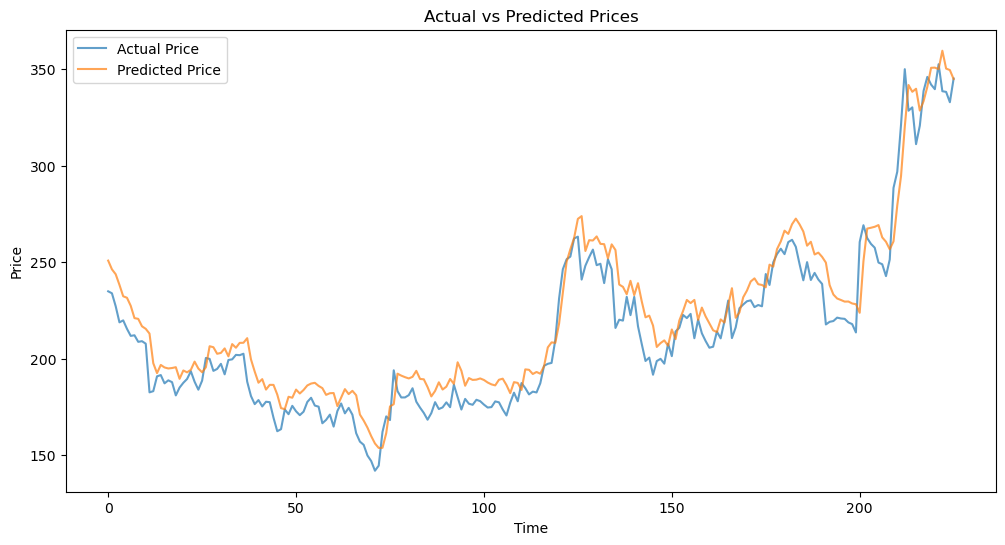

In [61]:
# 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled[:, 3], label='Actual Price', alpha=0.7)
plt.plot(predictions[:, 3], label='Predicted Price', alpha=0.7)
plt.title('Actual vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

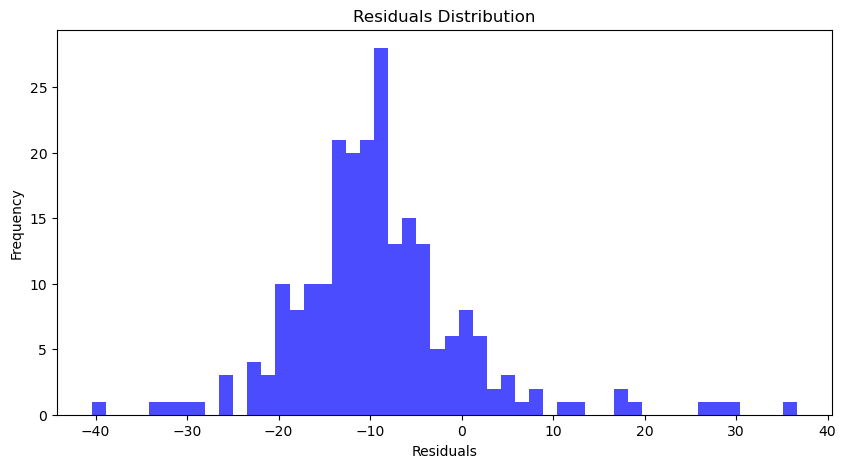

In [62]:
# 잔차 분석
residuals = y_test_rescaled[:, 3] - predictions[:, 3]
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=50, color='blue', alpha=0.7)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

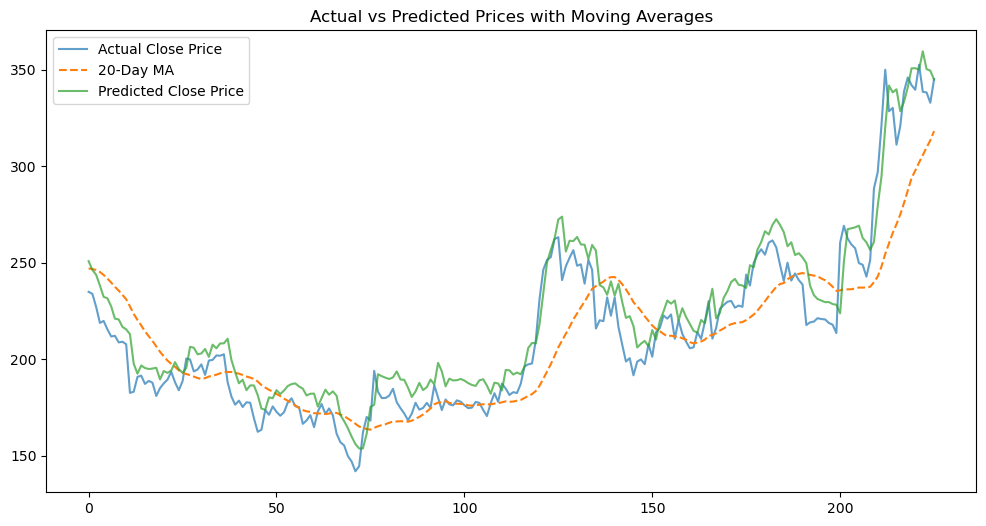

In [63]:
# 이동평균 비교
plt.figure(figsize=(12, 6))
plt.plot(data['Close'].values[-len(y_test_rescaled):], label='Actual Close Price', alpha=0.7)
plt.plot(data['MA20'].values[-len(y_test_rescaled):], label='20-Day MA', linestyle='--')
plt.plot(predictions[:, 3], label='Predicted Close Price', alpha=0.7)
plt.title('Actual vs Predicted Prices with Moving Averages')
plt.legend()
plt.show()